# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from time import time
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Найдём дубликаты

In [4]:
print(data.duplicated().sum())

4


Совсем не много, можем просто удалить 

In [5]:
data = data.drop_duplicates().reset_index(drop=True)

Избавимся от ненужных данных, данные колонки ни как не влияют на цену автомобился.

In [6]:
data_drop = data[['DateCrawled', 'DateCreated' ,'NumberOfPictures' ,'PostalCode' ,'LastSeen']]
data = data.drop(['DateCrawled', 'DateCreated' ,'NumberOfPictures' ,'PostalCode' ,'LastSeen'], axis=1)

In [7]:
data.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Посмотрим кол-во пропусков.

In [8]:
data.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
dtype: int64

Заполним все пропуски в колонке Repaired на no

In [9]:
data['Repaired'] = data['Repaired'].fillna('no')

Заполним пропуски в колонках FuelType, VehicleType, Gearbox, Model самыми популярными занчениями относительно группировки. 

In [10]:
data['FuelType'] = data['FuelType'].fillna(data.groupby(['Model','Power'], dropna=False)['FuelType']
                                           .transform(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan))

data['VehicleType'] = data['VehicleType'].fillna(data.groupby(['Model'], dropna=False)['VehicleType']
                                           .transform(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan))

data['Gearbox'] = data['Gearbox'].fillna(data.groupby(['Model','RegistrationYear'], dropna=False)['Gearbox']
                                           .transform(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan))

data['Model'] = data['Model'].fillna(data.groupby(['Brand','VehicleType'], dropna=False)['Model']
                                           .transform(lambda x: x.mode().iloc[0] if x.notna().any() else np.nan))

In [11]:
data.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox               303
Power                   0
Model                3376
Kilometer               0
RegistrationMonth       0
FuelType              448
Brand                   0
Repaired                0
dtype: int64

Удалим строки с отавшимися пропусками так как их кол-во не значительно.

In [12]:
data = data.dropna()

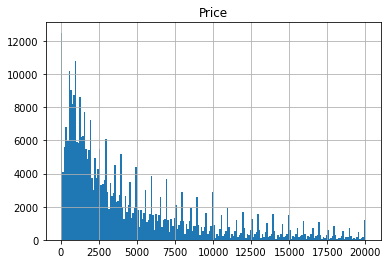

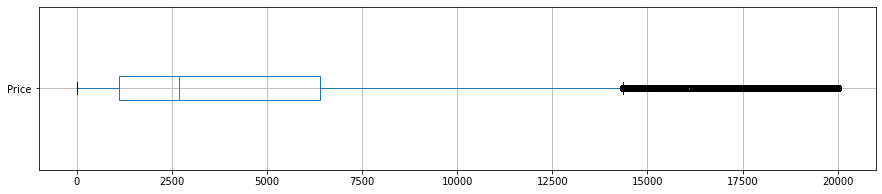

In [13]:
data.hist(['Price'], bins=200)
plt.show()
plt.figure(figsize=(15,3))
data.boxplot(['Price'], vert=False, )
plt.show()

Удалим выбросы

In [14]:
data = data.query('14450 > Price > 100')

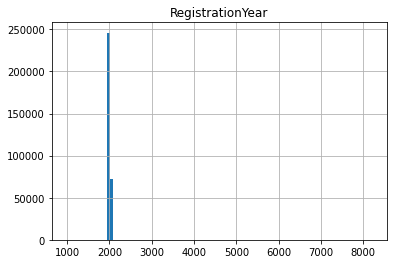

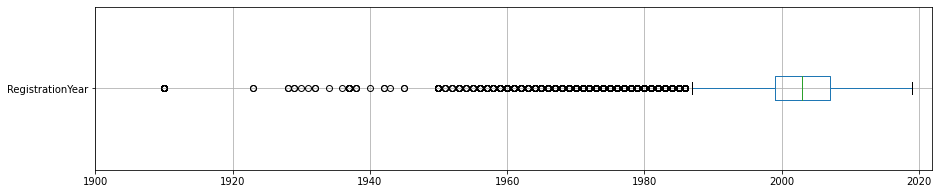

In [15]:
data.hist(['RegistrationYear'], bins=100)
plt.show()
plt.figure(figsize=(15,3))
data.boxplot(['RegistrationYear'], vert=False, )
plt.xlim(1900,2022)
plt.show()

Удалим строки с нереалистичными годами 

In [16]:
data_drop['DateCrawled'].max()

'2016-04-07 14:36:58'

In [17]:
data = data.query('2017 > RegistrationYear > 1900')

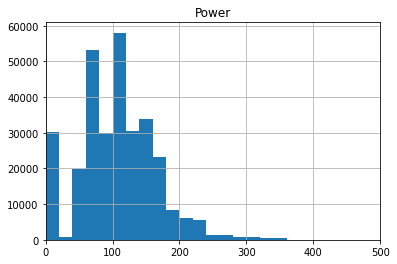

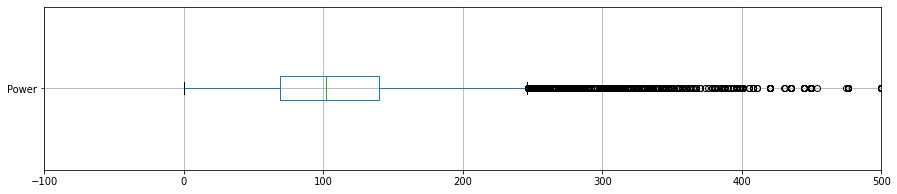

In [18]:
data.hist(['Power'], bins=1000)
plt.xlim(0,500)
plt.show()
plt.figure(figsize=(15,3))
data.boxplot(['Power'], vert=False, )
plt.xlim(-100,500)
plt.show()

Удалим строки с нереалистичными показателями мощности

In [19]:
data = data.query('400 > Power > 0')

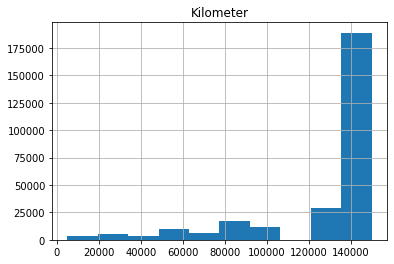

In [20]:
data.hist(['Kilometer'], bins=10)
plt.show()

Проверим уникальные знаечения категориальных данных и преобразуем их в числовые 

In [21]:
data['Repaired'] = data['Repaired'].transform(lambda x: 1 if x=='yes' else 0)

In [22]:
data['VehicleType'].unique()

array(['suv', 'small', 'sedan', 'convertible', 'wagon', 'bus', 'coupe',
       'other'], dtype=object)

In [23]:
data['Gearbox'].unique()

array(['auto', 'manual'], dtype=object)

In [24]:
data['Gearbox'] = data['Gearbox'].transform(lambda x: 1 if x=='auto' else 0)

In [25]:
data['FuelType'].unique()

array(['gasoline', 'petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [26]:
data['Brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'mazda',
       'renault', 'ford', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'nissan', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'jaguar', 'daewoo', 'rover', 'porsche', 'saab', 'trabant',
       'land_rover', 'lada'], dtype=object)

In [27]:
#data = data.query('index < 1000')

Разделим данные на признаки и цели.

In [28]:
features = data.drop(['Price'], axis=1)
target = data['Price']

Применим два типа преобразования категориальных данных OHE и OE, в дальнейшем будем проводить все исследования на двух выборках.

In [29]:
features_ohe = pd.get_dummies(features, drop_first=True)

In [30]:
encoder = OrdinalEncoder()
data_cat = features[['VehicleType','FuelType','Brand','Model']]
data_cat_oe = pd.DataFrame(encoder.fit_transform(data_cat), columns=data_cat.columns, index=data_cat.index)
features_oe =  pd.concat([features.drop(['VehicleType','FuelType','Brand','Model'],axis=1),
                          data_cat_oe] , join='inner', axis=1)


Разделяем выборки на тренировочную вилидационную и тестовую

In [31]:
features_ohe_t, features_ohe_test, target_ohe_t, target_ohe_test = train_test_split(features_ohe, target,
                                                                                    test_size=0.2, random_state=12345)
features_oe_t, features_oe_test, target_oe_t, target_oe_test = train_test_split(features_oe, target,
                                                                                 test_size=0.2, random_state=12345)

features_ohe_train, features_ohe_valid, target_ohe_train, target_ohe_valid = train_test_split(features_ohe_t, target_ohe_t,
                                                                                    test_size=0.25, random_state=12345)
features_oe_train, features_oe_valid, target_oe_train, target_oe_valid = train_test_split(features_oe_t, target_oe_t,
                                                                                    test_size=0.25, random_state=12345)

## Обучение моделей

Функция для подщёта RMSE

In [32]:
def RMSE (real, pred):
    return np.sqrt(mean_squared_error(real,pred))

Функция для подбора параметров и замера времяни (предсказания, обучения, подбора параметров) возвращает DataFrame с данными.

In [33]:
score = make_scorer(RMSE, greater_is_better=False)
results = pd.DataFrame(columns=['model','parametrs','encoding_type','rmse','time_fit','time_en','time_predict'])
     
def trainer (model_train, parameters):
    model = GridSearchCV(model_train, parameters, cv=5, scoring=score,)
    results = pd.DataFrame(columns=['model','parametrs','encoding_type','rmse','time_fit','time_en','time_predict'])
    
    start = time()
    model.fit(features_ohe_train,target_ohe_train)
    time_en = time() - start

    
    start = time()
    model.predict(features_ohe_valid)
    timepred = time() - start
  
    
    results = results.append({'model': model_train,
                              'parametrs': model.best_params_,
                              'encoding_type': 'OHE',
                              'rmse': -model.best_score_,
                              'time_en': time_en,
                              'time_fit': model.refit_time_ ,
                              'time_predict': timepred}, ignore_index=True) 

    start = time()
    model.fit(features_oe_train,target_oe_train)
    time_en = time() - start
   
    start = time()
    model.predict(features_oe_valid)
    timepred = time() - start
       
    results = results.append({'model': model_train,
                              'parametrs': model.best_params_,
                              'encoding_type': 'OE',
                              'rmse': -model.best_score_,
                              'time_en': time_en,
                              'time_fit': model.refit_time_ ,
                              'time_predict': timepred}, ignore_index=True) 
    return results

DecisionTreeRegressor

In [34]:
parametrs = {'max_depth': range(2, 12, 2),'random_state': [12345]}
model = DecisionTreeRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

RandomForestRegressor

In [ ]:
parametrs = {'n_estimators':range(10, 51, 10),'max_depth': range(2, 5),'random_state': [12345]}
model = RandomForestRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

LGBMRegressor

In [ ]:
parametrs = {'n_estimators':range(10, 51, 10),'max_depth': range(2, 5),'learning_rate': [0.1, 0.2, 0.4],'random_state': [12345]}
model = LGBMRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

CatBoostRegressor

In [ ]:
parametrs = {'n_estimators':range(10, 51, 10),'max_depth': range(2, 5),'learning_rate': [0.1, 0.2, 0.4],'random_state': [12345]}
model = CatBoostRegressor(verbose=False)
results = results.append(trainer(model,parametrs),  ignore_index=True)

XGBRegressor

In [ ]:
"""parametrs = {'n_estimators':range(10, 51, 10),'max_depth': range(2, 5),'learning_rate': [0.1, 0.2, 0.4],'random_state': [12345]}
model = XGBRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)"""

## Анализ моделей

Определим лучшую модель, параметры, метод кодирования.
Оценкой служит некий point посчитаный от среднего отношений колонок rmse, time_predict к их минимальным значениям.
Чем меньше значение тем лучше.

In [ ]:
def point (results,rmse_min,time_predict_min):
    return (results['rmse'] / rmse_min + results['time_predict'] / time_predict_min) / 2

In [ ]:
results['points'] = results.apply(point, args=(results['rmse'].min(),
                                               results['time_predict'].min()), axis=1)
results

In [ ]:
pd.set_option('display.max_colwidth', -1)
print('Лучшая модель и лучшеие парамерты',
      results[results['points'] == results['points'].min()][['model','parametrs','encoding_type']])

Проверим модель на тестовой выборке 

In [ ]:

model = CatBoostRegressor(learning_rate=0.4, max_depth= 4, n_estimators=50, random_state=12345)

start = time()
model.fit(features_oe_train,target_oe_train)
time_fit= time() - start

start = time()
predictions = model.predict(features_oe_test)
time_pred = time() - start

print('RMSE:', RMSE(target_oe_test,predictions), 'Время обучения:', time_fit, 'Время предсказания:', time_pred)

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей